In [25]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
from keras.models import model_from_json

In [31]:
df = pd.read_csv('imio.csv')
df.tail()

,Date,Close,High,Low,Open
995,2018-01-15,10741.549805,10782.650391,10713.799805,10718.500000
996,2018-01-16,10700.450195,10762.349609,10687.849609,10761.500000
997,2018-01-17,10788.549805,10803.000000,10666.750000,10702.450195
998,2018-01-18,10817.000000,10887.500000,10782.400391,10873.400391
999,2018-01-19,10894.700195,10906.849609,10793.900391,10829.200195


In [32]:
df.shape

(1000, 5)

In [33]:
df = df.dropna(axis=0, how='any')

In [34]:
df = df.drop(['Date'], axis=1)
df.head()

,Close,High,Low,Open
0,6221.149902,6358.299805,6211.299805,6301.250000
1,6211.149902,6221.700195,6171.250000,6194.549805
2,6191.450195,6224.700195,6170.250000,6220.850098
3,6162.250000,6221.500000,6144.750000,6203.899902
4,6174.600098,6192.100098,6160.350098,6178.049805


In [35]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [36]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [37]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [38]:
df = df.astype(float)

In [39]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

('X_train', (873, 20, 4))
('y_train', (873,))
('X_test', (97, 20, 4))
('y_test', (97,))


In [40]:
model = build_model([X_train.shape[2], window, 100, 1])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=True, input_shape=(None, 4))`
  


('Compilation Time : ', 0.014838933944702148)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


In [41]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    nb_epoch=300,
    validation_split=0.2,
    verbose=2)

Train on 698 samples, validate on 175 samples
Epoch 1/300
 - 1s - loss: 1.1389 - acc: 0.0000e+00 - val_loss: 0.4395 - val_acc: 0.0000e+00
Epoch 2/300
 - 0s - loss: 0.6731 - acc: 0.0000e+00 - val_loss: 0.3073 - val_acc: 0.0000e+00
Epoch 3/300
 - 0s - loss: 0.3712 - acc: 0.0000e+00 - val_loss: 0.1930 - val_acc: 0.0000e+00
Epoch 4/300
 - 0s - loss: 0.1578 - acc: 0.0000e+00 - val_loss: 0.1178 - val_acc: 0.0000e+00
Epoch 5/300
 - 0s - loss: 0.1286 - acc: 0.0000e+00 - val_loss: 0.0960 - val_acc: 0.0000e+00
Epoch 6/300
 - 0s - loss: 0.1216 - acc: 0.0000e+00 - val_loss: 0.0705 - val_acc: 0.0000e+00
Epoch 7/300
 - 0s - loss: 0.0996 - acc: 0.0000e+00 - val_loss: 0.0720 - val_acc: 0.0000e+00
Epoch 8/300
 - 0s - loss: 0.1016 - acc: 0.0000e+00 - val_loss: 0.0620 - val_acc: 0.0000e+00
Epoch 9/300
 - 0s - loss: 0.0896 - acc: 0.0000e+00 - val_loss: 0.0652 - val_acc: 0.0000e+00
Epoch 10/300
 - 0s - loss: 0.0896 - acc: 0.0000e+00 - val_loss: 0.0591 - val_acc: 0.0000e+00
Epoch 11/300
 - 0s - loss: 0.0876

Epoch 89/300
 - 0s - loss: 0.0514 - acc: 0.0000e+00 - val_loss: 0.0418 - val_acc: 0.0000e+00
Epoch 90/300
 - 0s - loss: 0.0519 - acc: 0.0000e+00 - val_loss: 0.0310 - val_acc: 0.0000e+00
Epoch 91/300
 - 0s - loss: 0.0532 - acc: 0.0000e+00 - val_loss: 0.0453 - val_acc: 0.0000e+00
Epoch 92/300
 - 0s - loss: 0.0610 - acc: 0.0000e+00 - val_loss: 0.0310 - val_acc: 0.0000e+00
Epoch 93/300
 - 0s - loss: 0.0511 - acc: 0.0000e+00 - val_loss: 0.0384 - val_acc: 0.0000e+00
Epoch 94/300
 - 0s - loss: 0.0519 - acc: 0.0000e+00 - val_loss: 0.0306 - val_acc: 0.0000e+00
Epoch 95/300
 - 0s - loss: 0.0467 - acc: 0.0000e+00 - val_loss: 0.0396 - val_acc: 0.0000e+00
Epoch 96/300
 - 0s - loss: 0.0462 - acc: 0.0000e+00 - val_loss: 0.0302 - val_acc: 0.0000e+00
Epoch 97/300
 - 0s - loss: 0.0430 - acc: 0.0000e+00 - val_loss: 0.0399 - val_acc: 0.0000e+00
Epoch 98/300
 - 0s - loss: 0.0466 - acc: 0.0000e+00 - val_loss: 0.0294 - val_acc: 0.0000e+00
Epoch 99/300
 - 0s - loss: 0.0438 - acc: 0.0000e+00 - val_loss: 0.0401

Epoch 177/300
 - 0s - loss: 0.0451 - acc: 0.0000e+00 - val_loss: 0.0276 - val_acc: 0.0000e+00
Epoch 178/300
 - 0s - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.0454 - val_acc: 0.0000e+00
Epoch 179/300
 - 0s - loss: 0.0619 - acc: 0.0000e+00 - val_loss: 0.0238 - val_acc: 0.0000e+00
Epoch 180/300
 - 0s - loss: 0.0397 - acc: 0.0000e+00 - val_loss: 0.0292 - val_acc: 0.0000e+00
Epoch 181/300
 - 0s - loss: 0.0397 - acc: 0.0000e+00 - val_loss: 0.0233 - val_acc: 0.0000e+00
Epoch 182/300
 - 0s - loss: 0.0376 - acc: 0.0000e+00 - val_loss: 0.0273 - val_acc: 0.0000e+00
Epoch 183/300
 - 0s - loss: 0.0359 - acc: 0.0000e+00 - val_loss: 0.0228 - val_acc: 0.0000e+00
Epoch 184/300
 - 0s - loss: 0.0322 - acc: 0.0000e+00 - val_loss: 0.0265 - val_acc: 0.0000e+00
Epoch 185/300
 - 0s - loss: 0.0337 - acc: 0.0000e+00 - val_loss: 0.0224 - val_acc: 0.0000e+00
Epoch 186/300
 - 0s - loss: 0.0352 - acc: 0.0000e+00 - val_loss: 0.0297 - val_acc: 0.0000e+00
Epoch 187/300
 - 0s - loss: 0.0360 - acc: 0.0000e+00 - val_l

Epoch 265/300
 - 0s - loss: 0.0359 - acc: 0.0000e+00 - val_loss: 0.0247 - val_acc: 0.0000e+00
Epoch 266/300
 - 0s - loss: 0.0374 - acc: 0.0000e+00 - val_loss: 0.0199 - val_acc: 0.0000e+00
Epoch 267/300
 - 0s - loss: 0.0362 - acc: 0.0000e+00 - val_loss: 0.0260 - val_acc: 0.0000e+00
Epoch 268/300
 - 0s - loss: 0.0385 - acc: 0.0000e+00 - val_loss: 0.0198 - val_acc: 0.0000e+00
Epoch 269/300
 - 0s - loss: 0.0343 - acc: 0.0000e+00 - val_loss: 0.0281 - val_acc: 0.0000e+00
Epoch 270/300
 - 0s - loss: 0.0348 - acc: 0.0000e+00 - val_loss: 0.0194 - val_acc: 0.0000e+00
Epoch 271/300
 - 0s - loss: 0.0327 - acc: 0.0000e+00 - val_loss: 0.0261 - val_acc: 0.0000e+00
Epoch 272/300
 - 0s - loss: 0.0347 - acc: 0.0000e+00 - val_loss: 0.0196 - val_acc: 0.0000e+00
Epoch 273/300
 - 0s - loss: 0.0345 - acc: 0.0000e+00 - val_loss: 0.0257 - val_acc: 0.0000e+00
Epoch 274/300
 - 0s - loss: 0.0329 - acc: 0.0000e+00 - val_loss: 0.0189 - val_acc: 0.0000e+00
Epoch 275/300
 - 0s - loss: 0.0325 - acc: 0.0000e+00 - val_l

In [45]:
from keras.models import load_model

model.save('my_model.h5')

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.02 MSE (0.14 RMSE)
Test Score: 0.04 MSE (0.21 RMSE)


In [46]:
diff = []
ratio = []
pred = model.predict(X_train)
print pred
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

[[  2.35741305e+00]
 [  2.35159945e+00]
 [  2.34361434e+00]
 [  2.32857776e+00]
 [  2.31666422e+00]
 [  2.29775286e+00]
 [  2.27937007e+00]
 [  2.26600623e+00]
 [  2.25493264e+00]
 [  2.23906684e+00]
 [  2.21455979e+00]
 [  2.18788791e+00]
 [  2.16404176e+00]
 [  2.14645362e+00]
 [  2.13884592e+00]
 [  2.13976598e+00]
 [  2.14851880e+00]
 [  2.16057920e+00]
 [  2.17178464e+00]
 [  2.18243432e+00]
 [  2.19175243e+00]
 [  2.19887471e+00]
 [  2.20221734e+00]
 [  2.20158792e+00]
 [  2.20229793e+00]
 [  2.19304681e+00]
 [  2.18047690e+00]
 [  2.17078090e+00]
 [  2.16771531e+00]
 [  2.16761804e+00]
 [  2.17248392e+00]
 [  2.18135715e+00]
 [  2.19687724e+00]
 [  2.21228409e+00]
 [  2.22800708e+00]
 [  2.24063683e+00]
 [  2.24797869e+00]
 [  2.25057626e+00]
 [  2.25054908e+00]
 [  2.24911594e+00]
 [  2.24448800e+00]
 [  2.23973322e+00]
 [  2.22812176e+00]
 [  2.21262550e+00]
 [  2.19759059e+00]
 [  2.18393302e+00]
 [  2.17447734e+00]
 [  2.16512275e+00]
 [  2.15175843e+00]
 [  2.12917304e+00]


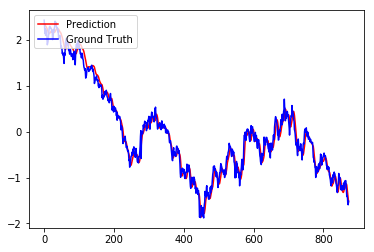

In [47]:
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_train, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()
%matplotlib inline

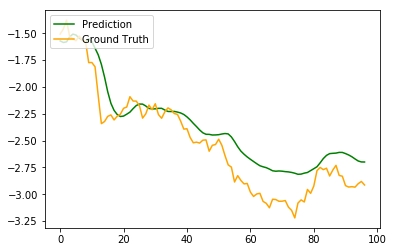

In [48]:
pred2 = model.predict(X_test)
plt2.plot(pred2, color='green', label='Prediction')
plt2.plot(y_test, color='orange', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()